In [2]:
import torch, torchvision
import sys, os
import numpy as np
sys.path.append('../')
from loader.MNIST_dataset import MNIST
from models import load_pretrained
from loader import get_dataloader
from geometry import get_pullbacked_Riemannian_metric
import matplotlib.pyplot as plt
from utils.utils import label_to_color, figure_to_array, PD_metric_to_ellipse
device = f'cuda:0'

## 1. Select Trained Model

In [19]:
# # MNIST digits 0, 1
# vae, cfg = load_pretrained(
#     identifier='MNIST/DIM_2/vae_mnist_01',
#     config_file='mnist_vae_z2.yml',
#     ckpt_file='model_best.pkl',
#     root='../results'
# )
# irvae, cfg = load_pretrained(
#     identifier='MNIST/DIM_2/irvae_mnist_01',
#     config_file='mnist_irvae_z2.yml',
#     ckpt_file='model_best.pkl',
#     root='../results'
# )

# # MNIST digits 0, 1, 5
# vae, cfg = load_pretrained(
#     identifier='MNIST/DIM_2/vae_mnist_015',
#     config_file='mnist_vae_z2.yml',
#     ckpt_file='model_best.pkl',
#     root='../results'
# )
# irvae, cfg = load_pretrained(
#     identifier='MNIST/DIM_2/irvae_mnist_015',
#     config_file='mnist_irvae_z2.yml',
#     ckpt_file='model_best.pkl',
#     root='../results'
# )

# MNIST digits 0, 1, 3, 6, 7
vae, cfg = load_pretrained(
    identifier='MNIST/DIM_2/vae_mnist_01367',
    config_file='mnist_vae_z2.yml',
    ckpt_file='model_best.pkl',
    root='../results'
)
irvae, cfg = load_pretrained(
    identifier='MNIST/DIM_2/irvae_mnist_01367',
    config_file='mnist_irvae_z2.yml',
    ckpt_file='model_best.pkl',
    root='../results'
)

vae.to(device);
irvae.to(device);

## 2. Get Data Loader

In [20]:
val_data_cfg = cfg['data']['validation']
val_data_cfg['root'] = '../dataset'
dl = get_dataloader(val_data_cfg)

MNIST split validation | torch.Size([5155, 1, 28, 28])


## 3. Data Encoding wiht VAE and IRVAE

In [21]:
num_points_for_each_class = 200
num_G_plots_for_each_class = 10
label_unique = torch.unique(dl.dataset.targets)
z_ = []
z_sampled_ = []
label_ = []
label_sampled_ = []
G_ = []
for label in label_unique:
    temp_data = dl.dataset.data[dl.dataset.targets == label][:num_points_for_each_class]
    temp_z = vae.encode(temp_data.to(device))
    z_sampled = temp_z[torch.randperm(len(temp_z))[:num_G_plots_for_each_class]]
    G = get_pullbacked_Riemannian_metric(vae.decode, z_sampled)

    z_.append(temp_z)
    label_.append(label.repeat(temp_z.size(0)))
    z_sampled_.append(z_sampled)
    label_sampled_.append(label.repeat(z_sampled.size(0)))
    G_.append(G)


vae_z_ = torch.cat(z_, dim=0).detach().cpu().numpy()
vae_label_ = torch.cat(label_, dim=0).detach().cpu().numpy()
vae_color_ = label_to_color(vae_label_)
vae_G_ = torch.cat(G_, dim=0).detach().cpu()
vae_z_sampled_ = torch.cat(z_sampled_, dim=0).detach().cpu().numpy()
vae_label_sampled_ = torch.cat(label_sampled_, dim=0).detach().cpu().numpy()
vae_color_sampled_ = label_to_color(vae_label_sampled_)

z_ = []
z_sampled_ = []
label_ = []
label_sampled_ = []
G_ = []
for label in label_unique:
    temp_data = dl.dataset.data[dl.dataset.targets == label][:num_points_for_each_class]
    temp_z = irvae.encode(temp_data.to(device))
    z_sampled = temp_z[torch.randperm(len(temp_z))[:num_G_plots_for_each_class]]
    G = get_pullbacked_Riemannian_metric(irvae.decode, z_sampled)

    z_.append(temp_z)
    label_.append(label.repeat(temp_z.size(0)))
    z_sampled_.append(z_sampled)
    label_sampled_.append(label.repeat(z_sampled.size(0)))
    G_.append(G)

irvae_z_ = torch.cat(z_, dim=0).detach().cpu().numpy()
irvae_label_ = torch.cat(label_, dim=0).detach().cpu().numpy()
irvae_color_ = label_to_color(irvae_label_)
irvae_G_ = torch.cat(G_, dim=0).detach().cpu()
irvae_z_sampled_ = torch.cat(z_sampled_, dim=0).detach().cpu().numpy()
irvae_label_sampled_ = torch.cat(label_sampled_, dim=0).detach().cpu().numpy()
irvae_color_sampled_ = label_to_color(irvae_label_sampled_)

## 4. Visualize Encodings

### 4.1 VAE

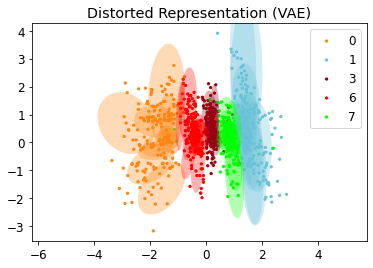

In [22]:
plt.rc('font', size=12)
index = cfg['data']['training']['digits'].split('_')[1]
size = 5

f = plt.figure(0)
z_scale = np.minimum(np.max(vae_z_, axis=0), np.min(vae_z_, axis=0))
eig_mean = torch.svd(vae_G_).S.mean().item()
scale = 0.1 * z_scale * np.sqrt(eig_mean)
alpha = 0.3
for idx in range(len(vae_z_sampled_)):
    e = PD_metric_to_ellipse(np.linalg.inv(vae_G_[idx,:,:]), vae_z_sampled_[idx,:], scale, fc=vae_color_sampled_[idx,:]/255.0, alpha=alpha)
    plt.gca().add_artist(e)
for label in label_unique:
    label = label.item()
    plt.scatter(vae_z_[vae_label_==label,0], vae_z_[vae_label_==label,1], c=vae_color_[vae_label_==label]/255, label=label, s=size)
plt.legend()
plt.axis('equal')
plt.title('Distorted Representation (VAE)')
# plt.savefig(f'../figure/vae{index}.png')
plt.show()

### 4.2 IRVAE

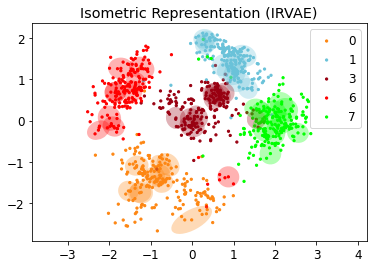

In [23]:
f = plt.figure(1)
z_scale = np.minimum(np.max(irvae_z_, axis=0), np.min(irvae_z_, axis=0))
eig_mean = torch.svd(irvae_G_).S.mean().item()
scale = 0.1 * z_scale * np.sqrt(eig_mean)
alpha = 0.3
for idx in range(len(irvae_z_sampled_)):
    e = PD_metric_to_ellipse(np.linalg.inv(irvae_G_[idx,:,:]), irvae_z_sampled_[idx,:], scale, fc=irvae_color_sampled_[idx,:]/255.0, alpha=alpha)
    plt.gca().add_artist(e)
for label in label_unique:
    label = label.item()
    plt.scatter(irvae_z_[irvae_label_==label,0], irvae_z_[irvae_label_==label,1], c=irvae_color_[irvae_label_==label]/255, label=label, s=size)
plt.legend()
plt.axis('equal')
plt.title('Isometric Representation (IRVAE)')
# plt.savefig(f'../figure/irvae{index}.png')
plt.show()

### 4.3 Traditional Manifold Leanring (IsoMap)

In [24]:
from sklearn.manifold import Isomap
X = dl.dataset.data
X = X.view(len(X), -1)

embedding = Isomap(n_components=2)
X_transformed = embedding.fit_transform(X)
X_transformed = torch.tensor(X_transformed, dtype=torch.float)

In [25]:
num_points_for_each_class = 200
z_ = []
label_ = []
for label in label_unique:
    temp_z = X_transformed[dl.dataset.targets == label][:num_points_for_each_class]
    z_.append(temp_z)
    label_.append(label.repeat(temp_z.size(0)))

isomap_z_ = torch.cat(z_, dim=0).detach().cpu().numpy()
isomap_label_ = torch.cat(label_, dim=0).detach().cpu().numpy()
isomap_color_ = label_to_color(isomap_label_)

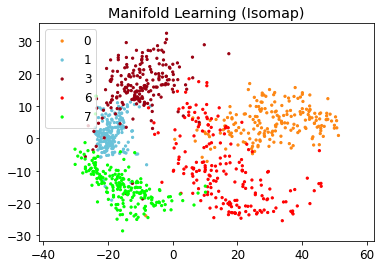

In [28]:
f = plt.figure(2)
for label in label_unique:
    label = label.item()
    plt.scatter(isomap_z_[isomap_label_==label, 0], isomap_z_[isomap_label_==label, 1], c=isomap_color_[isomap_label_==label]/255, label=label, s=size)
plt.legend()
plt.axis('equal')
plt.title('Manifold Learning (Isomap)')
# plt.savefig(f'../figure/Isomap{index}.png')
plt.show()

## 5. Interpolations

In [14]:
label1 = 0
label2 = 1

In [15]:
X = dl.dataset.data
y = dl.dataset.targets
data1 = X[y == label1][0:1].to(device)
data2 = X[y == label2][0:1].to(device)

In [16]:
z1_irvae = irvae.encode(data1)
z2_irvae = irvae.encode(data2)
z1_vae = vae.encode(data1)
z2_vae = vae.encode(data2)

In [17]:
linterp_irvae = torch.cat([z1_irvae + (z2_irvae-z1_irvae) * t/19 for t in range(20)], dim=0)
linterp_vae = torch.cat([z1_vae + (z2_vae-z1_vae) * t/19 for t in range(20)], dim=0)
x_interp_irvae = irvae.decode(linterp_irvae).detach().cpu()
x_interp_vae = vae.decode(linterp_vae).detach().cpu()

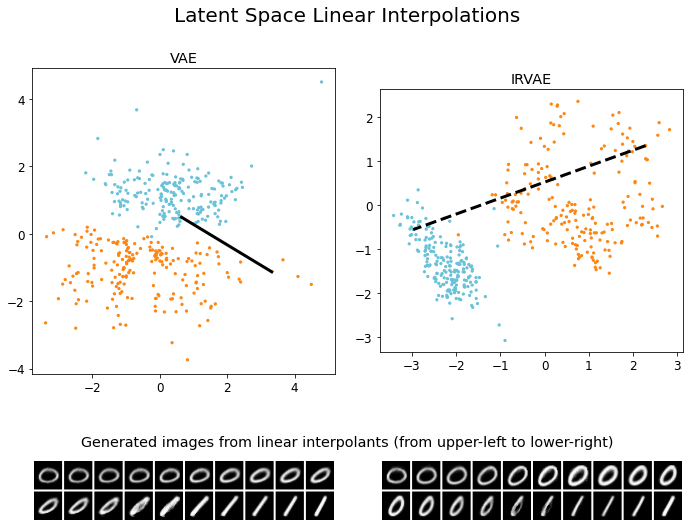

In [18]:
f = plt.figure(3, figsize=(10,10))
plt.rc('font', size=12)
index = cfg['data']['training']['digits'].split('_')[1]
size = 5

ax1 = f.add_subplot(2, 2, 1)
ax2 = f.add_subplot(2, 2, 2) 
ax3 = f.add_subplot(2, 2, 3)
ax4 = f.add_subplot(2, 2, 4)

for label in label_unique:
    label = label.item()
    ax1.scatter(vae_z_[vae_label_==label,0], vae_z_[vae_label_==label,1], c=vae_color_[vae_label_==label]/255, label=label, s=size)
ax1.plot(linterp_vae[:,0].detach().cpu(), linterp_vae[:,1].detach().cpu(), linewidth=3, color='k')
ax1.set_aspect('equal')
ax1.set_title('VAE')

for label in label_unique:
    label = label.item()
    ax2.scatter(irvae_z_[irvae_label_==label,0], irvae_z_[irvae_label_==label,1], c=irvae_color_[irvae_label_==label]/255, label=label, s=size)
ax2.plot(linterp_irvae[:,0].detach().cpu(), linterp_irvae[:,1].detach().cpu(), '--', linewidth=3, color='k')
ax2.set_aspect('equal')
ax2.set_title('IRVAE')

ax3.imshow(
    torchvision.utils.make_grid(
        torch.cat([x_interp_vae], dim=0), nrow=10, value_range=(0, 1), pad_value=1
        ).permute(1,2,0))
ax3.axis('off')

ax4.imshow(
    torchvision.utils.make_grid(
        torch.cat([x_interp_irvae], dim=0), nrow=10, value_range=(0, 1), pad_value=1
        ).permute(1,2,0))
ax4.axis('off')

f.supxlabel('Generated images from linear interpolants (from upper-left to lower-right)', y=0.385)
f.tight_layout(pad=2, h_pad=0)
plt.suptitle('Latent Space Linear Interpolations', fontsize=20, y=1)
plt.savefig(f'../figure/LSLI{index}.png', bbox_inches='tight')
plt.show()